<a href="https://colab.research.google.com/github/stefdepr/deep_learning/blob/main/dense_network_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.8.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
60000  original train samples
10000  original test samples
Using  50000  train samples,  10000  validation samples and  10000  test samples
Each sample has  784  features
Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2022/GA1/
gdrive	sample_data
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 2048)              1607680   
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0         
                                                                 
 dense_64 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_65 (Dense)            (None, 10)     

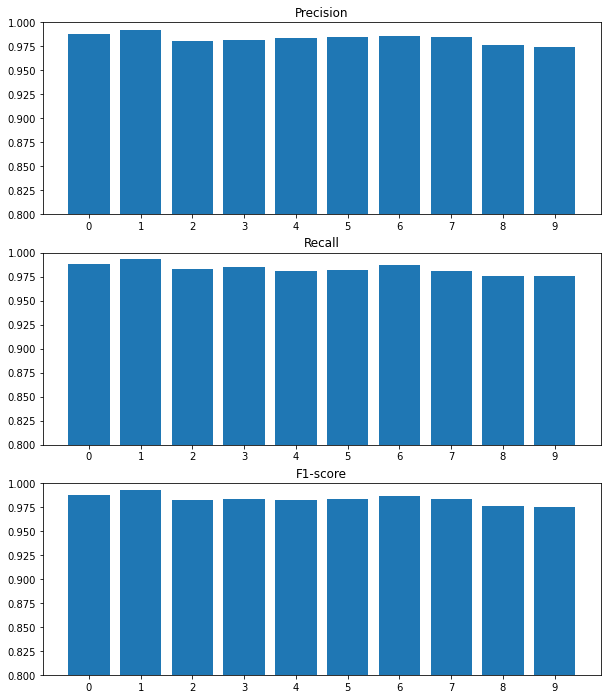

precision: [0.9877551  0.99207746 0.98067633 0.98126233 0.98365679 0.98537683
 0.98541667 0.98533724 0.97636177 0.97428289]
recall: [0.9877551  0.99295154 0.98352713 0.98514851 0.98065173 0.98206278
 0.9874739  0.98054475 0.97535934 0.97621407]
fscore: [0.9877551  0.99251431 0.98209966 0.98320158 0.98215196 0.98371701
 0.98644421 0.98293515 0.9758603  0.97524752]
The first 9 misclassified samples look like this:


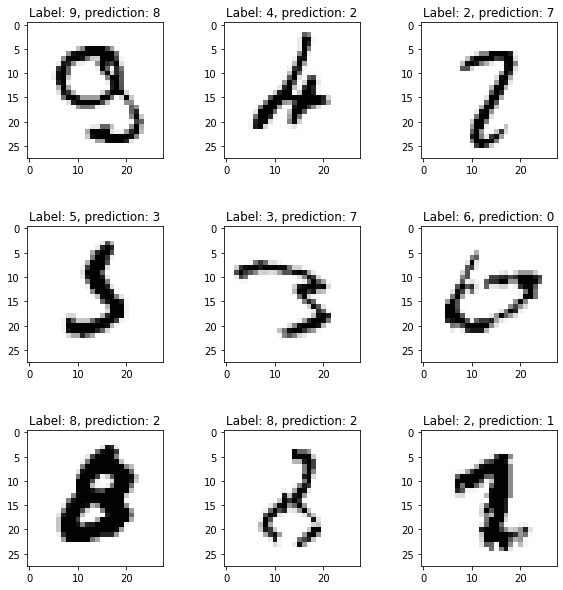

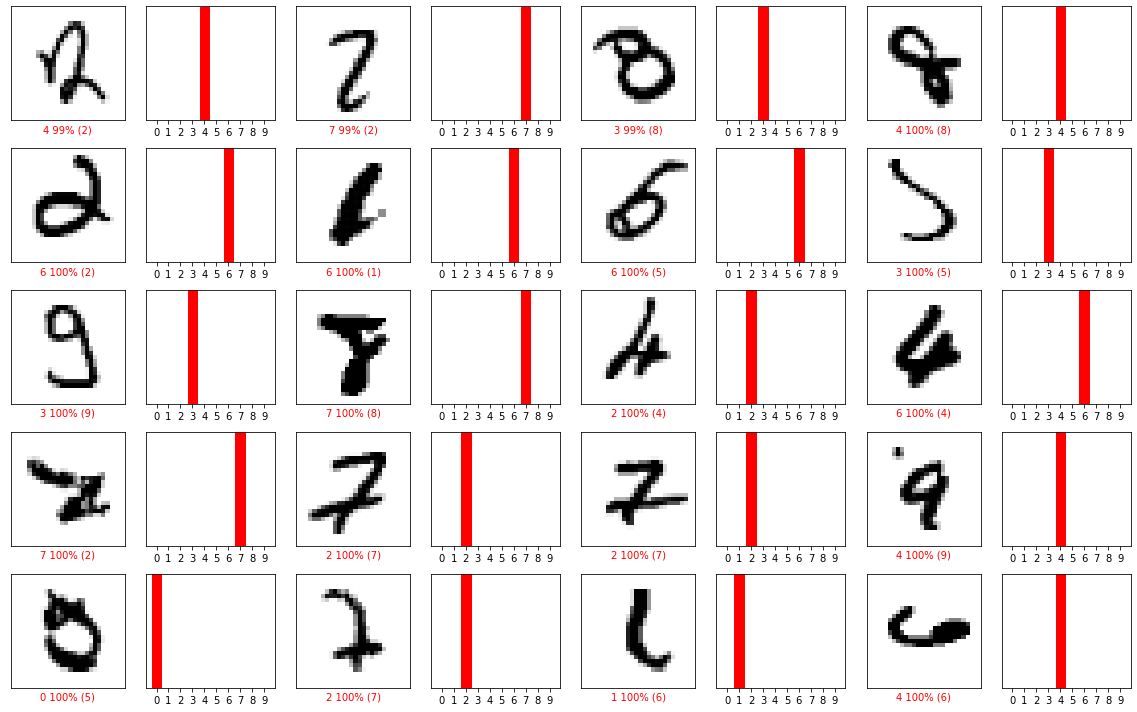

Confusion matrix, without normalization


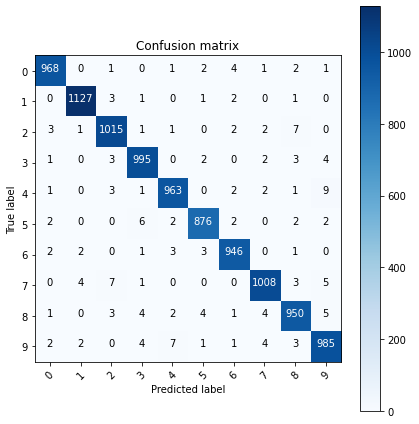

Normalized confusion matrix


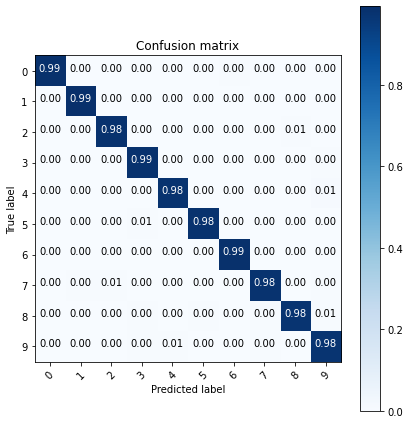

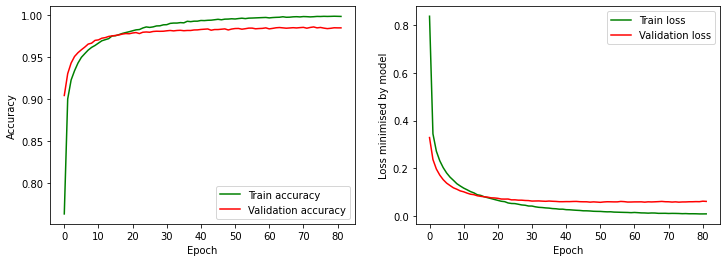

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.constraints import maxnorm

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2022
np.random.seed(seed)

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


# helper functions for visualisation

# same function as in the getting started notebook,
# but now plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['accuracy']), 'g-',
             label='Train accuracy')
    plt.plot(history.epoch, np.array(history.history['val_accuracy']), 'r-',
             label='Validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss minimised by model')
    plt.plot(history.epoch, np.array(history.history['loss']), 'g-',
             label='Train loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), 'r-',
             label='Validation loss')
    plt.legend()


from google.colab import drive

drive.mount('/content/gdrive')

import os

# !ls '/content/gdrive/My Drive/'

# load train and test data
(x_train_all, r_train_all_class), (x_test, r_test_class) = mnist.load_data()
x_train_all = x_train_all.reshape(x_train_all.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
x_train_all = x_train_all.astype('float32')
x_test = x_test.astype('float32')
x_train_all /= 255
x_test /= 255

print(x_train_all.shape[0], ' original train samples')
print(x_test.shape[0], ' original test samples')

# This data set contains a train set and test set
# we still need to split off a validation set

# Number of test samples
N_test = x_test.shape[0]

# split off 10000 samples for validation
N_val = 10000
N_train = x_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state to make sure you get the same split each time
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=N_val,
                                                              random_state=0)

#N_train = 10000
N_train = 50000

x_train = x_train[:N_train, :]
r_train_class = r_train_class[:N_train]

print("Using ", x_train.shape[0], " train samples, ", x_val.shape[0], " validation samples and ", x_test.shape[0],
      " test samples")
print("Each sample has ", x_train.shape[1], " features")

# The features in this data set are the pixels of a 28x28 pixel image
# You can visualise an individual image as follows
# (here for the first 9 images in the training set)


# The labels are numbers from 0 to 9


r_train_all = keras.utils.to_categorical(r_train_all_class)
r_train = keras.utils.to_categorical(r_train_class)
r_val = keras.utils.to_categorical(r_val_class)
r_test = keras.utils.to_categorical(r_test_class)

# look at the new labels for the first sample


num_classes = 10


# this first network has 2 hidden layers
# the first layer needs to be told explicitly what the input shape is
# the output layer has 10 neurons: one neuron per class

# Note that we use the "He" initialisation scheme here, since this is often advised
# for layers with ReLu neurons - although you are free to change this, it is not necessary for this assignment

# Also note that "dropout" is implemented in separate layers in Keras
# they are added below in comment to show you how to use them
# note that you can also start your network with a dropout layer (randomly setting input features to 0)

def initial_model():
    # create linear model
    model = Sequential()
    # we start with a first fully connected layer
    
    model.add(Dense(2048, activation='relu', input_shape=(784,), kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l2=0.000001) ))

    model.add(Dropout(0.5))
    # a second dense layer with half as many neurons
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    

    # and the output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.00005),  # set to default learning rate here
                  metrics=['accuracy'])  # save accuracy in addition to cross entropy error
    return model


# Model checkpoints are saved versions of intermediate models during training

# Set the path for saving intermediate model checkpoints

# With the setting below, models will be dumped in your drive in the specified folder (make this folder first)
# Change this path name to a unique path for each model you want to keep (otherwise they will be overwritten)
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2022/GA1/"
print("Models will be saved in ", checkpoint_dir)
# Have a look what is already in that path
!ls
"{checkpoint_dir}"

model_savename = checkpoint_dir + "initialmodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir + "cp-{epoch:04d}.ckpt"

# Create your model
model_1 = initial_model()
model_1.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 300
epochs = 100

# Modelcheckpoint callback:
# - save at every epoch if 'save_best_only'=false
# - save complete model if 'save weights only' = false

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Set early stopping: with parameters below, training will stop
# when validation accuracy hasn't improved for 6 epochs
# (or when the total number of epochs has passed)
# If necessary, you can also set a threshold, ignoring all improvements below the threshold
#stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.0001)

# NOTE that it may be useful NOT to use early stopping while you are tisll tuning learning convergence
# also be sure to adapt the patience in order to allow convergence

# Putting verbose = 1 below (instead of 0 i the previous notebook) plots out 1 line per epoch
history_1 = model_1.fit(x_train, r_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[cp_callback, stopping_callback],
                        validation_data=(x_val, r_val)
                        )
# If you want to save the weights of this trained model, run:
model_1.save_weights(model_savename)

# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

[test_loss, test_accuracy] = model_1.evaluate(x_test, r_test, verbose=0)
print("Test set Accuracy:{:7.4f}".format(test_accuracy))
print("Test set Loss:{:7.6f}\n".format(test_loss))

predictions = model_1.predict(x_test)
test_predicted_class = np.argmax(predictions, axis=1)
misclassified = np.where(test_predicted_class != r_test_class)[0]

print("There are ", misclassified.shape[0], " misclassified samples in the test set.")

from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, f1, _ = score(r_test_class, test_predicted_class)

names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.bar(names, precision)
plt.ylim([0.8, 1])
plt.title("Precision")
plt.subplot(3, 1, 2)
plt.bar(names, recall)
plt.title("Recall")
plt.ylim([0.8, 1])
plt.subplot(3, 1, 3)
plt.bar(names, f1)
plt.ylim([0.8, 1])
plt.title("F1-score")
plt.show()

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(f1))

print("The first 9 misclassified samples look like this:")

f = plt.figure(figsize=(10, 10));
for idx in range(9):
    mis_index = misclassified[idx]
    plt.subplot(3, 3, idx + 1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label: " + str(r_test_class[mis_index])
              + ", prediction: " + str(test_predicted_class[mis_index]))
    plt.imshow(np.reshape(x_test[mis_index, :], (28, 28)), cmap='Greys', interpolation='None')


# the functions below have been borrowed/adapted from the notebook:
# https://www.tensorflow.org/tutorials/keras/classification


# this function plots the image with some annotations
def plot_image(predictions, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                         100 * np.max(predictions),
                                         true_label),
               color=color)


# this function shows the predictions for this sample
def plot_value_array(predictions, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


# probabilities for class that will be predicted
maxprob = np.max(predictions, axis=1)

# find 20 most certain misclassified samples
most_certain = np.argsort(maxprob[misclassified])
most_certain = misclassified[most_certain[-20:]]

# now we visualise the samples we found

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    idx = most_certain[i]
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(predictions[idx], r_test_class[idx], np.reshape(x_test[idx], (28, 28)))
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(predictions[idx], r_test_class[idx])
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(true_labels, predictions,
                          classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    num_classes = max(len(np.unique(true_labels)), len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)), len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# An unnormalised confusion matrix shows the numbers of samples in each combination of true class/predicted class

plot_confusion_matrix(r_test_class, test_predicted_class)

plot_confusion_matrix(r_test_class, test_predicted_class, normalize=True)




# Now we visualise what happened during training
plot_history(history_1)